# Global (Imports, Constants, Utils etc) 



## GPU type

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 13 02:08:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 32%   34C    P5    20W / 170W |    875MiB / 12045MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Module & Goggle Drive import

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install keras_tuner
except:
  pass

In [3]:
import os
import sys
import tensorflow as tf
import tensorflow.keras as keras
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm
from pickle import (
    dump,
    load
)

from tensorflow.keras import (
    layers,
    Model,
    Sequential,
    optimizers
)
from tensorflow.keras.preprocessing.sequence import (
    pad_sequences    
)

from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer



## Constant definision

In [4]:
# If runs on google colab or not
try:
  import google.colab
  BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/drone_research"
except:
  BASE_DIR = "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps"

DATA_FOLDER_NAME = "data"
DATA_FOLDER_PATH = os.path.join(BASE_DIR, DATA_FOLDER_NAME)
MODELS_FOLDER_NAME = "models"
MODELS_FOLDER_PATH = os.path.join(BASE_DIR, MODELS_FOLDER_NAME)
TUNERS_FOLDER_NAME = "tuners"
TUNERS_FOLDER_PATH = os.path.join(BASE_DIR, TUNERS_FOLDER_NAME)


OUTPUT_DATA_COLUMNS = ["position_x", "position_y", "position_z"]


INPUT_SEQUENCE_COLUMNS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z",
                          "angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "angular_velocity_x", "angular_velocity_y", "angular_velocity_z",
                          "orientation_x", "orientation_y", "orientation_z", "orientation_w", "motor_state_timestamp",
                          "barometer_altitude", "barometer_pressure", 
                          "barometer_qnh", 
                          "barometer_timestamp",                          
                          "magnetometer_magnetic_field_body_x", "magnetometer_magnetic_field_body_y",
                          "magnetometer_magnetic_field_body_z", "magnetometer_timestamp",
                          "rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                          "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                          "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                          "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler",
                          "rotor_timestamp"
                         ]

OUTPUT_SEQUENCE_COLUMNS = ["position_x", "position_y", "position_z"]

ACCELOMETER_SENSORS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z",
                       "angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                       "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                       "angular_velocity_x", "angular_velocity_y", "angular_velocity_z"]
ORIENTATION_SENSORS = ["orientation_x", "orientation_y", "orientation_z", "orientation_w"]
MAGNOMETER_SENSORS = ["magnetometer_magnetic_field_body_x", 
                      "magnetometer_magnetic_field_body_y",
                      "magnetometer_magnetic_field_body_z"]
BAROMETER_SENSORS = ["barometer_altitude", "barometer_pressure", "barometer_qnh"]
ROTOR_SENSORS = ["rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                 "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                 "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                 "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler"]

TIMESTAMP_COLUMNS = ["motor_state_timestamp", "barometer_timestamp", 
                     "magnetometer_timestamp", "rotor_timestamp"]


MAIN_TIMESTAMP_COLUMN = "motor_state_timestamp"
INPUT_SEQUENCE_LENGTH = 10


In [5]:
def get_recordings_files():
    all_csv_files = os.listdir(DATA_FOLDER_PATH)

    # Orders the "manual" files to the end (They are more likely represent 
    # the test user). So this data should be used as test
    auto_genereted_flights = [recording_file for recording_file in all_csv_files 
                              if not recording_file.startswith("manual")]
    manual_generated_flights = [recording_file for recording_file in all_csv_files 
                              if recording_file.startswith("manual")]

    all_csv_files = []
    all_csv_files.extend(auto_genereted_flights)
    all_csv_files.extend(manual_generated_flights)

    return all_csv_files


In [6]:
# Set float 64
tf.keras.backend.set_floatx('float32')

## Utils


### Save and Load models

In [7]:
def save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "wb") as file:
        dump(model, file)

    with open(scaler_x_file_path, "wb") as file:
        dump(scaler_x, file)

    with open(scaler_y_file_path, "wb") as file:
        dump(scaler_y, file)
        
def load_model_with_scalers_binary(model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "rb") as file:
        model = load(file)

    with open(scaler_x_file_path, "rb") as file:
        scaler_x = load(file)

    with open(scaler_y_file_path, "rb") as file:
        scaler_y = load(file)

    return model, scaler_x, scaler_y

## Data Split

In [8]:
def split_data(data: np.array, train_per = 0.95, dev_per= 0.5):
    """
    Splits data into train, dev and test
    :return:
    """
    data_len = len(data)

    train, dev, test = np.split(data, [int(train_per * data_len),
                                       int((dev_per + train_per) * data_len)])

    return train, dev, test


### Shuffle dataset

In [9]:
def shuffle_data_set(x_data: np.array, y_data: np.array):
    example_amount = x_data.shape[0]
    shuffle_indexes = np.random.permutation(example_amount)
    
    x_data = x_data[shuffle_indexes]
    y_data = y_data[shuffle_indexes]

    return x_data, y_data

# Data Preprocessing

### Load from single file

In [10]:
# Loads data from recording file
# Converts timestamp -> time offset from last timestamp
#          location  -> step made from last location in x time offset

def _convert_timestamp_to_interval_seconds(flight_input_df: pd.DataFrame, timestamp_columns: list):
    """
    Converts the timestamp fields into the amount of seconds between each two timestamps

    Note: each timestamp represents the amount eof NANO seconds (1,000,000,000 nanoseconds = 1 seconds)
    """
    # Converts the start time to time interval
    next_time_df = flight_input_df[timestamp_columns].shift(-1)
    time_diff_df = (next_time_df - flight_input_df[timestamp_columns]) / 1_000_000_000
    flight_input_df.loc[:, timestamp_columns] = time_diff_df
    return flight_input_df

def _convert_position_to_step(flight_output_df: pd.DataFrame):
    next_position_df = flight_output_df.shift(-1)
    position_diff = flight_output_df - next_position_df

    return position_diff
    
def load_flight_steps_from_file(csv_name: str, input_columns: list, output_columns: list):
    """

    @param csv_name:
    @param input_columns:
    @param output_columns:
    @return:
    """
    if not csv_name.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    csv_path = os.path.join(DATA_FOLDER_PATH, csv_name)
    flight_df = pd.read_csv(csv_path)

    x_df = flight_df[input_columns].copy()
    timestamp_columns = [column for column in input_columns if column in TIMESTAMP_COLUMNS]
    x_df = _convert_timestamp_to_interval_seconds(x_df, timestamp_columns)

    y_df = flight_df[output_columns].copy()
    y_df = _convert_position_to_step(y_df)
    
    # Drops the last record because the process is based of difference
    x_df.drop(x_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    return x_df, y_df

In [11]:
def load_dataset(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @return:
    """
    all_csv_files = get_recordings_files()

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df)
            y_sessions.append(y_df)

        except ValueError as error:
            print(str(error))

    x_df = pd.concat(x_sessions, ignore_index=True)
    y_df = pd.concat(y_sessions, ignore_index=True)

    return x_df, y_df


### Preprocess data

In [12]:
def preprocess_ann_dataset(x_df: pd.DataFrame, y_df : pd.DataFrame):
    scaler_x = ColumnTransformer([
          ("rotor_sensors", StandardScaler(), ["rotor_a_speed", "rotor_b_speed",
                                            "rotor_c_speed", "rotor_d_speed"]),
          ("accelerator_values", MinMaxScaler((-1,1)), ACCELOMETER_SENSORS),
          ("orientation", MinMaxScaler((-1,1)), ORIENTATION_SENSORS),
          ("barometer", MinMaxScaler(), BAROMETER_SENSORS),
          ("magnetometer_x_y", MinMaxScaler((-1,1)),["magnetometer_magnetic_field_body_x", 
                                           "magnetometer_magnetic_field_body_y"]),
          ("magnetometer_z", MinMaxScaler(),["magnetometer_magnetic_field_body_z"]),                      
          ("rotors_other", MinMaxScaler(),["rotor_a_thrust", "rotor_a_torque_scaler",
                                           "rotor_b_thrust", "rotor_b_torque_scaler",
                                           "rotor_c_thrust", "rotor_c_torque_scaler",
                                           "rotor_d_thrust", "rotor_d_torque_scaler",]),
          ],
          remainder='passthrough')
    
    scaler_y = MinMaxScaler()

    data_x = scaler_x.fit_transform(x_df)

    data_y = y_df.to_numpy()
    data_y = scaler_y.fit_transform(data_y)

    data_x = data_x.astype(np.float32)
    data_y = data_y.astype(np.float32)
    return data_x, data_y, scaler_x, scaler_y

In [13]:
def load_preprocessed_dataset(input_columns: list, output_columns: list):
    """
    Loads the whole dataset with preprocessing

    @param input_columns: Input columns names
    @param output_columns: Output columns names
    @param sequence_length: The size of input x sequence
    @return: Loaded, preprocessed, shuffled, splitted data set
    """
    x_data, y_data = load_dataset(input_columns, output_columns)
    x_data, y_data, scaler_x, scaler_y = preprocess_ann_dataset(x_data, y_data)

    train_x, dev_x, test_x = split_data(x_data, train_per=0.88, dev_per=0.12)
    train_y, dev_y, test_y = split_data(y_data, train_per=0.88, dev_per=0.12)

    return train_x, train_y, dev_x, dev_y, scaler_x, scaler_y

#Model creation and training 

In [146]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = \
    load_preprocessed_dataset(INPUT_SEQUENCE_COLUMNS, OUTPUT_SEQUENCE_COLUMNS)

recording_31Jan_01:14_33_record.csv - (1829, 38) - 0.2836569255559536%
recording_31Jan_00:53_5_record.csv - (2695, 38) - 0.7016205200738842%
recording_31Jan_01:14_32_record.csv - (2748, 38) - 1.1278038068031135%
recording_31Jan_00:08_6_record.csv - (5753, 38) - 2.020028133059757%
recording_30Jan_22:12_8_record.csv - (2263, 38) - 2.3709934816289877%
recording_30Jan_22:55_6_record.csv - (2011, 38) - 2.6828765200614773%
recording_31Jan_00:26_2_record.csv - (2675, 38) - 3.0977383439336346%
recording_30Jan_22:55_4_record.csv - (3860, 38) - 3.6963800785678504%
recording_30Jan_22:12_9_record.csv - (4337, 38) - 4.368999043103756%
recording_30Jan_21:50_2_record.csv - (9286, 38) - 5.809151153936225%
recording_30Jan_22:55_2_record.csv - (2093, 38) - 6.133751452016384%
recording_31Jan_01:14_8_record.csv - (3405, 38) - 6.661827904459261%
recording_31Jan_00:53_3_record.csv - (1767, 38) - 6.935869341013317%
recording_31Jan_01:14_29_record.csv - (2997, 38) - 7.400669672282422%
recording_30Jan_21:57_6_

In [148]:
def create_ann_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    model = Sequential([
        layers.Input(shape=(input_columns_amount)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(output_columns_amount, 
                     activation="sigmoid")
    ])
    
    model.compile(loss='mean_squared_error',
                  optimizer="adam")

    return model
    

def create_ann_tuned_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    input_layer = layers.Input(shape=(None, input_columns_amount))
    layer = layers.Dense(512, return_sequences=True, dropout=0.4)(input_layer)
    layer = layers.LSTM(16, return_sequences=True)(layer)
    layer = layers.Dense(16)(layer)
    output_layer = layers.Dense(output_columns_amount)(layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.005))

    return model

In [149]:
model = create_ann_model(len(INPUT_SEQUENCE_COLUMNS), len(OUTPUT_SEQUENCE_COLUMNS))
history = model.fit(train_x,
          train_y,
          epochs=50,
          batch_size=512,
          validation_data=(dev_x, dev_y))

Epoch 1/50
1134/1134 [==============================] - 2s 1ms/step - loss: 8.7782e-04 - val_loss: 2.1304e-05
Epoch 2/50
1134/1134 [==============================] - 1s 1ms/step - loss: 2.1620e-05 - val_loss: 2.1283e-05
Epoch 3/50
1134/1134 [==============================] - 1s 1ms/step - loss: 2.1350e-05 - val_loss: 2.0378e-05
Epoch 4/50
1134/1134 [==============================] - 1s 1ms/step - loss: 1.7831e-05 - val_loss: 1.5419e-05
Epoch 5/50
1134/1134 [==============================] - 1s 1ms/step - loss: 1.4411e-05 - val_loss: 6.4589e-06
Epoch 6/50
1134/1134 [==============================] - 1s 1ms/step - loss: 1.1440e-05 - val_loss: 3.0463e-06
Epoch 7/50
1134/1134 [==============================] - 1s 1ms/step - loss: 9.4612e-06 - val_loss: 2.6231e-06
Epoch 8/50
1134/1134 [==============================] - 1s 1ms/step - loss: 8.0154e-06 - val_loss: 1.2624e-06
Epoch 9/50
1134/1134 [==============================] - 1s 1ms/step - loss: 6.8254e-06 - val_loss: 1.0900e-06
Epoch 10/5

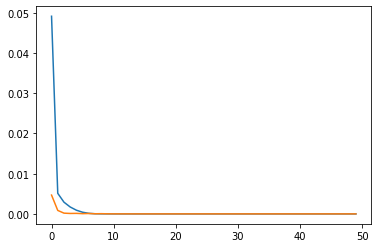

In [55]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

## Save model

In [151]:
model_name = "ann_13Mar22_best"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

INFO:tensorflow:Assets written to: ram://8877b701-57d0-4936-a1db-0577bdca4608/assets


# Hyperparameters tuning

### Model Creation

In [50]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [30]:
def create_dynamic_model(hp: kt.HyperParameters) -> Model:
    """
    Creates Sequence model dynamically
    :param hp: Hyper parameters (Initialized by a tuning algorithm)
    :return:
    """
    model = Sequential()
    model.add(layers.Input(shape=(hp.get("input_columns_amount"))))    
    activation = hp.Choice("dense_actiavtion", ["tanh", "relu", "sigmoid"])
    dense_layers = hp.Int("dense_layers", min_value=1, max_value=4)

    for layer_id in range(dense_layers):
      layer_units = hp.Int(f"dense_{layer_id}_units", min_value=16, max_value=256, step=16)

      model.add(layers.Dense(layer_units,
                             activation=activation,
                             kernel_regularizer=keras.regularizers.L2(
                                 hp.Choice(f"l2_regulator_{layer_id}", [0.0, 0.1, 0.01, 0.001]))))

      dropout_rate = hp.Float(f"dense_{layer_id}_dropout_rate", min_value=0, max_value=0.4, step=0.05)
      model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(hp.get("output_columns_amount")))

    learning_rate = hp.Choice("adam_learning_rate", [0.01, 0.001, 0.002, 0.005])

    if hp.Boolean(f"learning_rate_decay"):
        learning_rate = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=10000,
            decay_rate=0.9)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model



### The Tuner



In [31]:
hp = kt.HyperParameters()
hp.Fixed("input_columns_amount", len(INPUT_SEQUENCE_COLUMNS))
hp.Fixed("output_columns_amount", len(OUTPUT_SEQUENCE_COLUMNS))

project_name = "ann_12MarNight_position_with_regularizator"
tuner = kt.BayesianOptimization(
    create_dynamic_model,
    hyperparameters=hp,
    objective="val_loss",
    max_trials=1000,
    directory=TUNERS_FOLDER_PATH,
    project_name=project_name,
    executions_per_trial = 1
)

INFO:tensorflow:Reloading Oracle from existing project /home/israzex/Desktop/drone_homecoming_rl/artificial_gps/tuners/ann_12MarNight_position_with_regularizator/oracle.json


In [ ]:
# tuner.get_best_hyperparameters()[0].values

In [ ]:
model = tuner.get_best_models()[0]
model_name = "position_best_11Mar_1"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

569
441
16
INFO:tensorflow:Assets written to: ram://1ecd14e5-e86f-49e7-8616-9c7d73d12757/assets


2022-03-11 14:29:09.105149: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### Truning

In [ ]:
tensorboard_dir = os.path.join(os.path.join(TUNERS_FOLDER_PATH,project_name), "tensorboard")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, 
                                                      histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, baseline=0.00001)
tuner.search(train_x,
            train_y,
             validation_data=(dev_x, dev_y),
             epochs = 2000,
             batch_size=512,
             callbacks=[early_stop, tensorboard_callback])



# Position Test


In [31]:
                          
POISITON_INPUT_COLUMNS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z",
                          "angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "angular_velocity_x", "angular_velocity_y", "angular_velocity_z",
                          "orientation_x", "orientation_y", "orientation_z", "orientation_w", "motor_state_timestamp",
                          "barometer_altitude", "barometer_pressure", 
                          "barometer_qnh", 
                          "barometer_timestamp",                          
                          "magnetometer_magnetic_field_body_x", "magnetometer_magnetic_field_body_y",
                          "magnetometer_magnetic_field_body_z", "magnetometer_timestamp",
                          "rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                          "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                          "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                          "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler",
                          "rotor_timestamp"
                         ]
POISITON_OUTPUT_COLUMNS = ["position_x", "position_y", "position_z"]

SPEED_INPUT_COLUMNS = ["angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "angular_velocity_x", "angular_velocity_y", "angular_velocity_z",
                          "orientation_x", "orientation_y", "orientation_z", "orientation_w", "motor_state_timestamp",
                          "barometer_altitude", "barometer_pressure", 
                          "barometer_qnh", 
                          "barometer_timestamp",                          
                          "magnetometer_magnetic_field_body_x", "magnetometer_magnetic_field_body_y",
                          "magnetometer_magnetic_field_body_z", "magnetometer_timestamp",
                          "rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                          "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                          "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                          "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler",
                          "rotor_timestamp"
                         ]
SPEED_OUTPUT_COLUMNS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z"]


FLIGHT_DATA_CSV_NAME = "manual_31Jan_00:43_record.csv"

In [35]:
speed_model_name = "ann_speed_13Mar_best"
position_model_name = "ann_13Mar22_best"




try:
    speed_model, speed_scaler_x, speed_scaler_y = load_model_with_scalers_binary(speed_model_name)
    position_model, position_scaler_x, position_scaler_y = load_model_with_scalers_binary(position_model_name)
except FileNotFoundError:
    print(f"There is no model with name {speed_model_name} or {position_model_name}")

# Predicts velocity
flight_x_df, flight_y_df = load_flight_steps_from_file(FLIGHT_DATA_CSV_NAME, SPEED_INPUT_COLUMNS, SPEED_OUTPUT_COLUMNS)
copyed_x_df = flight_x_df.copy()
data_x = speed_scaler_x.transform(copyed_x_df)
data_x = data_x.astype(np.float32)

predicted_y = speed_model.predict(data_x)
predicted_y = speed_scaler_y.inverse_transform(predicted_y)

real_y = flight_y_df.to_numpy()
target_predicted_velocity = np.add.accumulate(predicted_y)
real_velocity = np.add.accumulate(real_y)

for record in zip(predicted_y, real_y):
  print(record)

for record in zip(target_predicted_velocity, real_velocity):
  print(record)

# Predicts position based on velocity 
flight_pos_x_df, flight_y_df = load_flight_steps_from_file(FLIGHT_DATA_CSV_NAME, POISITON_INPUT_COLUMNS, POISITON_OUTPUT_COLUMNS)

flight_x_df.insert(0, "linear_velocity_z", target_predicted_velocity[:,2])
flight_x_df.insert(0, "linear_velocity_y", target_predicted_velocity[:,1])
flight_x_df.insert(0, "linear_velocity_x", target_predicted_velocity[:,0])
copyed_x_df = flight_x_df.copy()

time_intervals = flight_pos_x_df[MAIN_TIMESTAMP_COLUMN].to_numpy().reshape(-1, 1)

data_x = position_scaler_x.transform(flight_pos_x_df)
data_x = data_x.astype(np.float32)

real_y = flight_y_df.to_numpy()
predicted_y = position_model.predict(data_x)
predicted_y = position_scaler_y.inverse_transform(predicted_y)

time_offset = np.add.accumulate(time_intervals)
predicted_offset = np.add.accumulate(predicted_y)
real_offset = np.add.accumulate(real_y)

time_stamps_to_print = list(range(10))
time_stamps_to_print.extend([15, 20, 25, 30, 40, 50, 100])
index = 0



Streaming output truncated to the last 5000 lines.
(array([0.7140074 , 0.34004548, 0.03595444], dtype=float32), array([-0.0112951 , -0.03087407,  0.03709817]))
(array([0.7133048 , 0.33925408, 0.03525434], dtype=float32), array([-0.01385085, -0.0378626 ,  0.03896409]))
(array([0.7135105 , 0.3384743 , 0.03478359], dtype=float32), array([-0.01171111, -0.03202201,  0.02689612]))
(array([0.7134899 , 0.33698702, 0.0343006 ], dtype=float32), array([-0.01195055, -0.03268298,  0.02318743]))
(array([0.7130814 , 0.33496183, 0.03405231], dtype=float32), array([-0.01455102, -0.03979701,  0.02364546]))
(array([0.71317184, 0.33683264, 0.03338596], dtype=float32), array([-0.01215581, -0.03324847,  0.01590782]))
(array([0.7132036 , 0.33589703, 0.03317603], dtype=float32), array([-0.01213615, -0.03319851,  0.01251984]))
(array([0.71318954, 0.33515802, 0.03289134], dtype=float32), array([-0.01453593, -0.03976649,  0.01118505]))
(array([0.7134052 , 0.33618635, 0.03258483], dtype=float32), array([-0.012064

In [33]:
for predicted, real, time_offset in zip(predicted_offset, real_offset, time_offset):
    if index < len(time_stamps_to_print) and \
            int(time_offset) == time_stamps_to_print[index]:
        print(
            f"position:\nreal offset:      {real}\npredicted offset: {predicted}\ntime offset(seconds): {time_offset}\n\n")
        index += 1



position:
real offset:      [-0.00019073  0.00011444 -0.00014877]
predicted offset: [ 0.00469363 -0.00194737 -0.00088267]
time offset(seconds): [0.01500032]


position:
real offset:      [-0.00750732  0.00413513 -0.06287384]
predicted offset: [ 0.2614889  -0.12136462 -0.12434047]
time offset(seconds): [1.01102131]


position:
real offset:      [-0.07205963  0.03535461 -0.0222435 ]
predicted offset: [ 0.36845058 -0.13429974 -0.11346382]
time offset(seconds): [2.01004314]


position:
real offset:      [-2.35118103  1.18012238  1.28240967]
predicted offset: [-2.3647764  0.765792   1.3872789]
time offset(seconds): [3.00906419]


position:
real offset:      [-8.17222595  4.30295563  2.79921341]
predicted offset: [-8.678682   4.0661387  2.7975304]
time offset(seconds): [4.01108531]


position:
real offset:      [-10.87771606   5.78964233   4.16371155]
predicted offset: [-11.705053    5.6933446   4.228198 ]
time offset(seconds): [5.00410675]


position:
real offset:      [-11.65855408   6.219